In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Example image
### Full image

In [2]:
data_path = "../SOCOFing/Real/"

In [3]:
def ax_remove_borders(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
def show_image(image):
    fig, ax = plt.subplots(1, 1)
    ax_remove_borders(ax)
    ax.imshow(image)

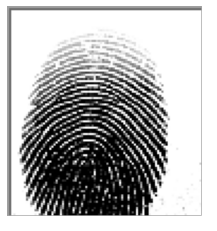

In [4]:
im = Image.open(f'{data_path}1__M_Left_little_finger.BMP')
show_image(im)

In [5]:
single_image_size = np.array(im.size)
print(im.format, single_image_size, im.mode)

BMP [ 96 103] RGBA


### Image part

In [6]:
vertical_parts = 3
horizontal_parts = 3
part_size_percent = 0.7
part_size = (single_image_size * part_size_percent).astype(int)
print(part_size)

[67 72]


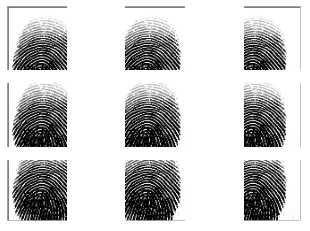

In [7]:
(leftover_width, leftover_height) = single_image_size - part_size

fig, ax = plt.subplots(vertical_parts, horizontal_parts)
for x in range(vertical_parts):
    for y in range(horizontal_parts):
        ax_remove_borders(ax[x, y])
        box = np.array([
            y * leftover_width / (horizontal_parts - 1), 
            x * leftover_height / (vertical_parts - 1)
        ]).astype(int)
        box = (*box, *(box + part_size))
        region = im.crop(box)
        ax[x, y].imshow(region)

### Image part augmentation

In [8]:
max_rotation = 15
max_perspective = 0.15
noise_strength = 0.4
fade_at_edges_strength = 0.8

https://stackoverflow.com/questions/14177744/how-does-perspective-transformation-work-in-pil
https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/

In [9]:
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])
        
    A = np.matrix(matrix, dtype=np.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

#### Rotation and perspective

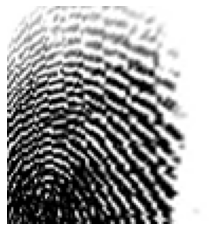

In [10]:
im_augmented = im.rotate(np.random.randint(-max_rotation, max_rotation))

width, height = im_augmented.size

def adjust_points(x, y):
    x1 = x + (-1 if x > 0 else 1) * np.random.uniform(0, 0.3) * width
    y1 = y + (-1 if y > 0 else 1) * np.random.uniform(0, 0.3) * height
    return x1, y1

points = [(0, 0), (width, 0), (width, height), (0, height)]
new_points = [adjust_points(x, y) for x, y in points]

coeffs = find_coeffs(points, new_points)

im_augmented = im_augmented.transform(im.size, Image.PERSPECTIVE, coeffs, Image.BICUBIC)

show_image(im_augmented)

#### Cutting part with proper size

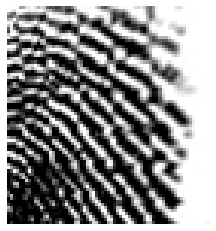

In [11]:
box = np.array([np.random.randint(leftover_width), np.random.randint(leftover_height)])
box = (*box, *(box + part_size))
region = im_augmented.crop(box)

show_image(region)

In [12]:
im_arr = np.array(region)
width, height, _ = im_arr.shape

#### Noise

In [13]:
noise = np.random.randint(0, 255 * noise_strength, (width, height))

In [14]:
for x in range(width):
    for y in range(height):
        value = min(255, im_arr[x, y][0] + noise[x, y])
        im_arr[x, y] = np.array([value, value, value, im_arr[x, y][3]])

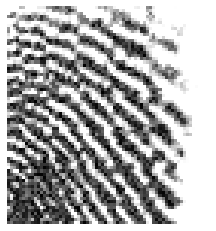

In [15]:
new_im = Image.fromarray(im_arr)
show_image(new_im)

#### Fade at the edges

In [16]:
mid_width, mid_height = width / 2, height / 2
mid = np.array([mid_width, mid_height])

max_distance = np.linalg.norm(np.array([0, 0]) - mid)

sin_f = lambda x: np.sin(np.pi / 2 * x)
log_f = lambda x: -np.log(-0.9 * x + 1)

def add_fade(arr, function=(lambda x: x)):
    for x in range(width):
        for y in range(height):
            distance = np.linalg.norm(np.array([x, y]) - mid)
            percent_distance = distance / max_distance
            percent_added_value = function(percent_distance)
            added_value = 255 * percent_added_value * fade_at_edges_strength
            value = min(255, arr[x, y][0] + added_value)
            arr[x, y] = np.array([value, value, value, arr[x, y][3]])

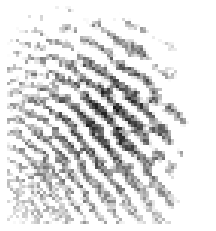

In [17]:
# linear fade

tmp_arr = im_arr.copy()
add_fade(tmp_arr)
new_im = Image.fromarray(tmp_arr)
show_image(new_im)

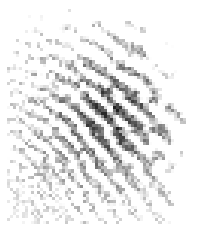

In [18]:
# sinus fade

tmp_arr = im_arr.copy()
add_fade(tmp_arr, sin_f)
new_im = Image.fromarray(tmp_arr)
show_image(new_im)

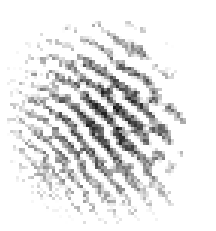

In [19]:
# log fade

tmp_arr = im_arr.copy()
add_fade(tmp_arr, log_f)
new_im = Image.fromarray(tmp_arr)
show_image(new_im)

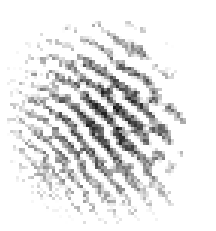

In [20]:
add_fade(im_arr, log_f)
new_im = Image.fromarray(im_arr)
show_image(new_im)